In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools



from iarchitect import envs,trainer as trainer_iarch
from iarchitect.agents import dqn as dqn_iarch,ddpg as ddpg_iarch
from iarchitect.common import show_policy_behaviour
from iarchitect.callbacks import output_updater

from tf_agents.agents import ddpg
from tf_agents.agents import DdpgAgent,DqnAgent


from tf_agents.utils import common
from tf_agents import networks
from tf_agents.networks import sequential
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics,tf_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

from tensorflow import Tensor,Variable,convert_to_tensor
from tensorflow.keras import layers,Input,Model
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras import initializers


2022-03-03 13:16:37.793640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-03 13:16:37.793688: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



# Utils

## Utils

In [5]:
def show_agent_behavior(tf_env,agent,ax,axes):
    results = show_policy_behaviour(tf_env,trainer.agent.policy,50)
#     ax.plot([r[0] for r in results],label="action")
    ax.plot([r[1] for r in results],label="reward")
    n = min(len(results),len(axes))
    for ax_,res in zip(axes[:n],[r[2] for r in results[:n]]):
        ax_.imshow(res.reshape(res.shape[1:-1]))

## Plot

In [6]:
def fig_trainer(r,c):
    assert r%3==0
    fig = plt.figure(figsize=(20,20))
    gs = GridSpec(r, c,width_ratios=[1,1]+[1/(c-2)]*(c-2))
    ax = fig.add_subplot(gs[0:r//3,0])
    ax2 = fig.add_subplot(gs[r//3:r//3*2,0])
    ax3 = fig.add_subplot(gs[r//3*2:,0])
    ax4 = fig.add_subplot(gs[:,1])
    axes =[fig.add_subplot(gs[i,j+2]) for i,j in itertools.product(range(r),range(c-2))]
    return fig

In [7]:
def update_plotter(fig):
    def update_plot(step,trainer):
        
        for ax in fig.axes:
            ax.clear()
        
        ax,ax2,ax3,ax4 = fig.axes[:4]
        axes = fig.axes[4:]

        ax.plot(trainer.metrics,label="metric",color="green")
        losses = trainer.losses.reshape((-1,2))
        ax2.plot(losses[:,0],label="actor_loss",color="red")
        ax2.plot(losses[:,1],label="critic_loss",color="green")
        
        trainer.observer.plot_reward(ax=ax3,slice_=slice(-50,None,None))
        trainer.observer.plot_action(ax=ax3,slice_=slice(-50,None,None))
        show_agent_behavior(trainer.tf_env,trainer.agent,ax4,axes)
        ax.legend()
        ax2.legend()        
    return update_plot

In [8]:
def policy_plotter(fig):
    ax = fig.axes[0]
    def update(step,trainer):
        ax.clear()
        agent = trainer.agent
        time_step = trainer.tf_env.current_time_step()
        results = show_policy_behaviour(trainer.tf_env,agent.collect_policy,1000,one_episode_only=False)
        results =np.array([r[0].reshape((-1,)) for r in results[1:]])
        for c in range(results.shape[1]):
            ax.hist(results[:,c],bins=16,label=f"col_pol {c}")
        results = show_policy_behaviour(trainer.tf_env,agent.policy,1000,one_episode_only=False)
        results =np.array([r[0].reshape((-1,)) for r in results[1:]])
        for c in range(results.shape[1]):
            ax.hist(results[:,c],bins=16,label=f"pol {c}")
    return update

In [77]:
def buffer_plotter(fig):
    ax = fig.axes[0]
    def update(step,trainer):
        ax.clear()
        # HEAT MAP OBS
#         a = np.squeeze(trainer.replay_buffer.gather_all().observation.numpy()).sum(axis=0)
#         a/a.max()
#         ax.imshow(a,cmap="coolwarm")
        # HIST SOMME GRILLE
#         a = np.squeeze(trainer.replay_buffer.gather_all().observation.numpy())
#         print(a[-3,])
#         a = a.sum(axis=(1,2))
#         print(a)
#         ax.hist(a,bins=15)
        # SCATTER DES POSITIONS
#         a = np.squeeze(trainer.replay_buffer.gather_all().action.numpy()).transpose()
#         ax.scatter(a[0,:],a[1,:])
    return update

# Examples

## 

In [79]:
environment = envs.TensorEnv(4,action_float=True,
                            fail_on_same=True,
                             rewards_as_delta = False,
                             action_scalar = True,
                           rewards = {
                     "already_filled":-0.1,
                     "max_iter":0,
                     "new_value":0.5,
                     "success":1,
                     "coeff_round":0.1
                 })
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

### Networks

In [12]:
from tf_agents.networks import sequential
def get_critic_0(obs_spec,action_spec):
    # Observation as input
    obs_in = Input(shape=obs_spec.shape+(1,))
    obs_out = layers.Conv2D(obs_spec.shape[0], (2,2), strides=(1,1), activation="relu")(obs_in)
    obs_out = layers.Conv2D(obs_spec.shape[0], (2,2), strides=(1,1), activation="relu")(obs_out)
    obs_out = layers.Flatten()(obs_out)
    

    # Action as input
    action_input = Input(shape=action_spec.shape)
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([obs_out, action_out])

    out = layers.Dense(10, activation="relu")(concat)
    out = layers.Dense(10, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = Model([obs_in, action_input], outputs)

    return model

In [13]:
def get_critic_1(obs_spec,action_spec):
    return ddpg.critic_network.CriticNetwork(
            (obs_spec, action_spec),
            observation_conv_layer_params=[(20,(2,2),(1,1))]*2,
            joint_fc_layer_params = [10]*2+[1]
            )

In [102]:
def get_critic_2(obs_spec,action_spec):
    print(obs_spec.shape[1])
    return ddpg.critic_network.CriticNetwork(
            (obs_spec, action_spec),
#             observation_fc_layer_params=[obs_spec.shape[1]]*5,
#             joint_fc_layer_params = [obs_spec.shape[1]]*5+[1]
        observation_conv_layer_params=None,
        observation_fc_layer_params=[16,16],
        action_fc_layer_params=[4,4],
        action_dropout_layer_params=[0.20,0.20],
        joint_fc_layer_params = [20,16,4]
            )

In [15]:
def get_actor_0(obs_spec,action_spec):
    # Observation as input
    obs_in = Input(shape=obs_spec.shape)
    obs_out = layers.Dense(32, activation="relu")(obs_in)
    obs_out = layers.Dense(32, activation="relu")(obs_out)
    obs_out = layers.Dense(action_spec.shape[0], activation="relu")(obs_out)
    model = Model(obs_in, obs_out)
    return model

In [16]:
def get_actor_1(observation_spec, action_spec):
    return ddpg.actor_network.ActorNetwork(
    observation_spec, action_spec,
    fc_layer_params=(100,50),
)


In [95]:
def get_actor_2(observation_spec, action_spec):
    network = ddpg.actor_network.ActorNetwork(
    observation_spec, action_spec,
    dropout_layer_params=[0.2,0.2,0.2],
    fc_layer_params=[16,32,32],
    kernel_initializer = initializers.RandomUniform(
            minval=-10, maxval=10,)
        
)
    return network

In [96]:
from tensorflow import nest
    
def get_actor_3(observation_spec, action_spec):
    network = ddpg.actor_network.ActorNetwork(
    observation_spec, action_spec,
    dropout_layer_params=[0.2,0.2,0.2],
    fc_layer_params=[16,32,2],
    kernel_initializer = initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))
    network._mlp_layers.pop()
    flat_action_spec = nest.flatten(action_spec)
    network._mlp_layers.append(
        layers.Dense(
            flat_action_spec[0].shape.num_elements(),
            activation="softmax",
            name='action'))        

    return network

### Agent

In [103]:
# stddev = environment.dimension**2/2*0.8
stddev = 1

tup = train_env.observation_spec(),train_env.action_spec()
agent = ddpg_iarch.agent_factory(
    train_env,
    actor_network=get_actor_2(*tup),
    critic_network=get_critic_2(*tup),
     kwargs_agent = {"critic_optimizer":optimizers.Adam(learning_rate=0.0005),
                    "actor_optimizer":optimizers.Adam(learning_rate=0.0005),
                    "ou_stddev":stddev,
                    "summarize_grads_and_vars":True,
                    "debug_summaries":True,
                    "target_update_tau":1,
                    "target_update_period":1}
)

4


#### HyperParametesr

##### Noise

4
4
4
4
4
4
4
4
4
4
4
4


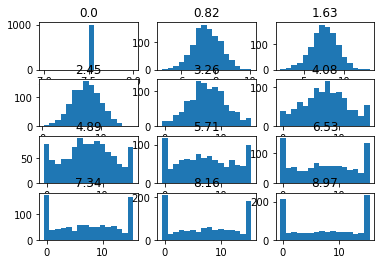

In [39]:
fig,axes = plt.subplots(4,3)
for ou,ax in zip(np.linspace(0,15.5,20),fig.axes[:20]):
    agent = ddpg_iarch.agent_factory(
        train_env,
        actor_network=get_actor_2(*tup),
        critic_network=get_critic_2(*tup),
         kwargs_agent = {"critic_optimizer":optimizers.Adam(learning_rate=0.0005),
                        "actor_optimizer":optimizers.Adam(learning_rate=0.0005),
                        "ou_stddev":ou}
    )
    results =[agent.collect_policy.action(train_env.reset()).action.numpy()[0] for _ in range(1000)]
    ax.hist(results,bins=16)
    ax.set(title = f"{round(ou,2)}")


In [34]:
agent.collect_policy

4
4
4
4
4
4
4
4
4
4


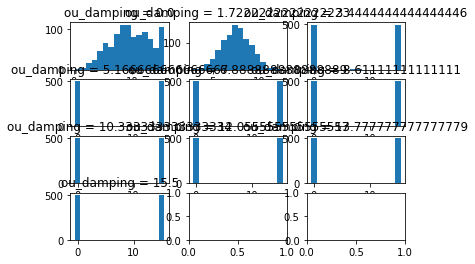

In [30]:
fig,axes = plt.subplots(4,3)
for ou,ax in zip(np.linspace(0,15.5,10),fig.axes[:10]):
    agent = ddpg_iarch.agent_factory(
        train_env,
        actor_network=get_actor_2(*tup),
        critic_network=get_critic_2(*tup),
         kwargs_agent = {"critic_optimizer":optimizers.Adam(learning_rate=0.0005),
                        "actor_optimizer":optimizers.Adam(learning_rate=0.0005),
                        "ou_damping":ou}
    )
    time_step = ts.restart(train_env.step(np.array(1)))
    results =[agent.collect_policy.action(train_env.reset()).action.numpy()[0] for _ in range(1000)]
    ax.hist(results,bins=16)
    ax.set(title = f"ou_damping = {ou}")

##### Collect Policy

In [109]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
            agent.collect_data_spec,
            batch_size=train_env.batch_size,
            max_length=100)

In [110]:
replay_buffer.clear()
dynamic_episode_driver.DynamicEpisodeDriver(
            train_env,
            agent.collect_policy,
            observers=[replay_buffer.add_batch],
            num_episodes=10).run()

(TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 4, 4, 1), dtype=int32, numpy=
 array([[[[0],
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          [0]]]], dtype=int32)>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>}),
 ())

In [130]:
result = replay_buffer.gather_all()
result

Trajectory(
{'action': <tf.Tensor: shape=(1, 46), dtype=float32, numpy=
array([[ 2.4753823,  0.7051449, 10.444516 ,  8.7093935,  8.132087 ,
        11.957317 , -0.49     ,  6.527989 , 13.938608 , 13.862241 ,
        -0.49     , 10.889443 ,  3.689029 ,  8.642638 ,  8.503097 ,
        -0.49     , -0.49     ,  1.2865176, 11.22961  ,  0.6331744,
        -0.49     ,  4.391723 ,  1.3436284,  8.655187 ,  4.9471006,
         3.2707243,  7.331904 ,  3.3405576, -0.49     ,  3.6541522,
         3.4299407,  8.862137 ,  6.3184314, 15.49     , -0.4464445,
        10.196189 , 14.643438 ,  6.2175636, 15.49     , 15.49     ,
         3.4402385, 10.170099 ,  5.381979 ,  8.263031 ,  4.6570177,
         4.006624 ]], dtype=float32)>,
 'discount': <tf.Tensor: shape=(1, 46), dtype=float32, numpy=
array([[1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.]],
     

(array([7., 4., 1., 6., 3., 2., 3., 1., 7., 0., 4., 2., 0., 2., 4.]),
 array([-0.49     ,  0.5753333,  1.6406666,  2.7059999,  3.7713332,
         4.8366666,  5.902    ,  6.9673333,  8.032666 ,  9.098    ,
        10.163333 , 11.228666 , 12.294    , 13.359333 , 14.424666 ,
        15.49     ], dtype=float32),
 <BarContainer object of 15 artists>)

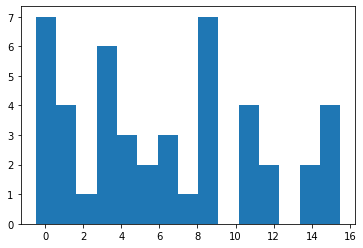

In [122]:
plt.hist(result.action.numpy().reshape((-1,)),bins=15)

In [126]:
ds = replay_buffer.as_dataset(sample_batch_size=3,num_steps=2)
iterator = iter(ds)

In [129]:
[iterator.next()[0].action.numpy() for _ in range(100)]

[array([[3.6541522, 3.4299407],
        [3.6541522, 3.4299407],
        [8.7093935, 8.132087 ]], dtype=float32),
 array([[ 6.527989 , 13.938608 ],
        [ 3.4402385, 10.170099 ],
        [-0.49     , -0.49     ]], dtype=float32),
 array([[3.4299407, 8.862137 ],
        [8.655187 , 4.9471006],
        [8.263031 , 4.6570177]], dtype=float32),
 array([[15.49     , -0.4464445],
        [15.49     , 15.49     ],
        [ 7.331904 ,  3.3405576]], dtype=float32),
 array([[10.444516 ,  8.7093935],
        [ 3.6541522,  3.4299407],
        [-0.49     ,  4.391723 ]], dtype=float32),
 array([[15.49     , -0.4464445],
        [ 8.132087 , 11.957317 ],
        [-0.49     , -0.49     ]], dtype=float32),
 array([[ 3.3405576, -0.49     ],
        [ 3.4299407,  8.862137 ],
        [ 3.4299407,  8.862137 ]], dtype=float32),
 array([[ 5.381979 ,  8.263031 ],
        [ 3.4402385, 10.170099 ],
        [10.196189 , 14.643438 ]], dtype=float32),
 array([[ 1.2865176, 11.22961  ],
        [15.49     , -0.44

In [98]:
iterator.next()[0].action

<tf.Tensor: shape=(64, 2), dtype=float32, numpy=
array([[7.4973702, 7.493822 ],
       [7.4973702, 7.493822 ],
       [7.493822 , 7.493822 ],
       [7.5      , 7.4973702],
       [7.493822 , 7.5      ],
       [7.5      , 7.4973702],
       [7.4973702, 7.493822 ],
       [7.493822 , 7.493822 ],
       [7.5      , 7.4973702],
       [7.493822 , 7.493822 ],
       [7.493822 , 7.493822 ],
       [7.493822 , 7.493822 ],
       [7.4973702, 7.493822 ],
       [7.4973702, 7.493822 ],
       [7.493822 , 7.493822 ],
       [7.4973702, 7.493822 ],
       [7.493822 , 7.493822 ],
       [7.493822 , 7.493822 ],
       [7.5      , 7.4973702],
       [7.493822 , 7.5      ],
       [7.5      , 7.4973702],
       [7.4973702, 7.493822 ],
       [7.493822 , 7.493822 ],
       [7.493822 , 7.493822 ],
       [7.5      , 7.4973702],
       [7.5      , 7.4973702],
       [7.4973702, 7.493822 ],
       [7.493822 , 7.5      ],
       [7.4973702, 7.493822 ],
       [7.493822 , 7.493822 ],
       [7.493822 , 7.

### Entrainement

In [98]:
trainer = trainer_iarch.Trainer(train_env,agent,loss_getter=lambda l:[l.extra.actor_loss,l.extra.critic_loss])
trainer.initialize_buffer(min_size=1000,random_policy=True)

#### Explore buffer

In [133]:
ds = trainer.replay_buffer.as_dataset(single_deterministic_pass=True,num_steps=2)

In [134]:
iterator=iter(ds)

In [135]:
results = []
for _ in range(100):
    elt,__ = next(iterator)
    obs = elt.observation.numpy()
    rew1,rew2 = elt.reward.numpy()
    obs1=obs[0,:,:,0]
    obs2=obs[1,:,:,0]
    coord1 = tuple(np.round(elt.action.numpy()[0,:]).astype(int))
    coord2 = tuple(np.round(elt.action.numpy()[1,:]).astype(int))
    obs1[coord1],obs1[coord2],obs2[coord1],obs2[coord2],rew1,rew2
    results.append(elt.action.numpy().transpose())
#     results.append(elt.reward.numpy())    

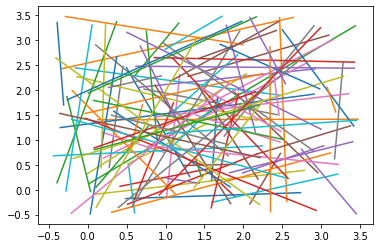

In [139]:
plt.plot(*results)
plt.show()

#### Trainer outut + launch

1.1342267125513672e-06

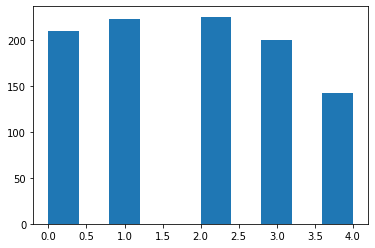

In [85]:
a = np.squeeze(trainer.replay_buffer.gather_all().observation.numpy()[0,],axis=-1)
a = a.sum(axis=(1,2))
plt.hist(a)
import math
math.factorial(16)/16**16

(array([278.,   0.,   0.,   0.,   0., 580.,   0.,   0.,   0., 142.]),
 array([-0.09932594,  0.01557737,  0.13048068,  0.245384  ,  0.3602873 ,
         0.4751906 ,  0.5900939 ,  0.70499724,  0.8199006 ,  0.93480384,
         1.0497072 ], dtype=float32),
 <BarContainer object of 10 artists>)

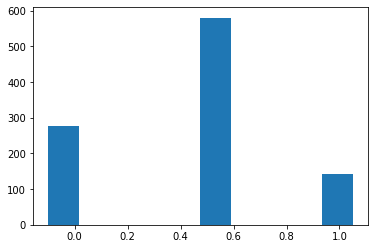

In [86]:
plt.hist(trainer.replay_buffer.gather_all().reward.numpy()[0,:])

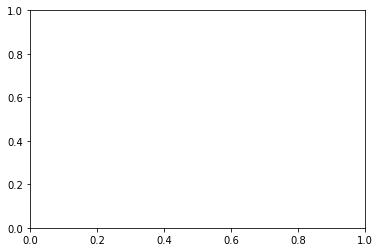

In [87]:
buffer_plotter(plt.subplots()[0])(0,trainer)

In [71]:
def weights_printer(num_layer,iis_neurons,fig):
    ax = fig.axes[0]
    weights = []
    def print_weights(step,trainer):
        ax.clear()
        layer = trainer.agent._actor_network._mlp_layers[num_layer]
        w = layer._trainable_weights
        
        for i in iis_neurons:
            weights.append((w[0].numpy()[i],w[1].numpy()[i])
        weights
    return print_weights

SyntaxError: invalid syntax (202427362.py, line 11)

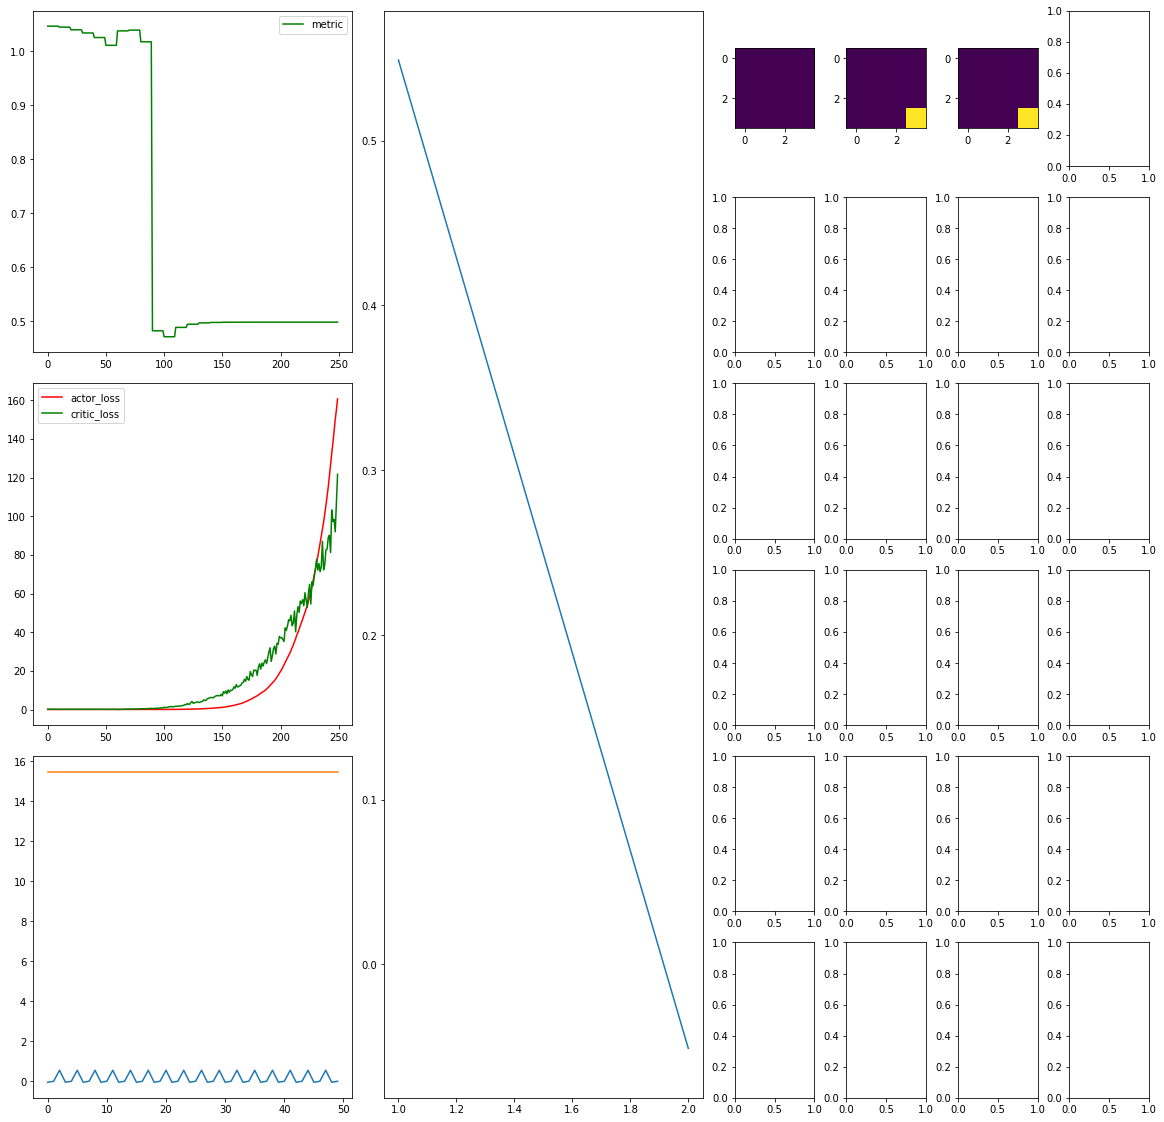

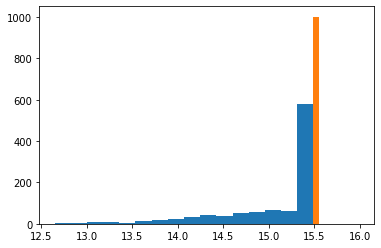

/home/maxime/.pyenv/versions/iarchitect/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


KeyboardInterrupt: 

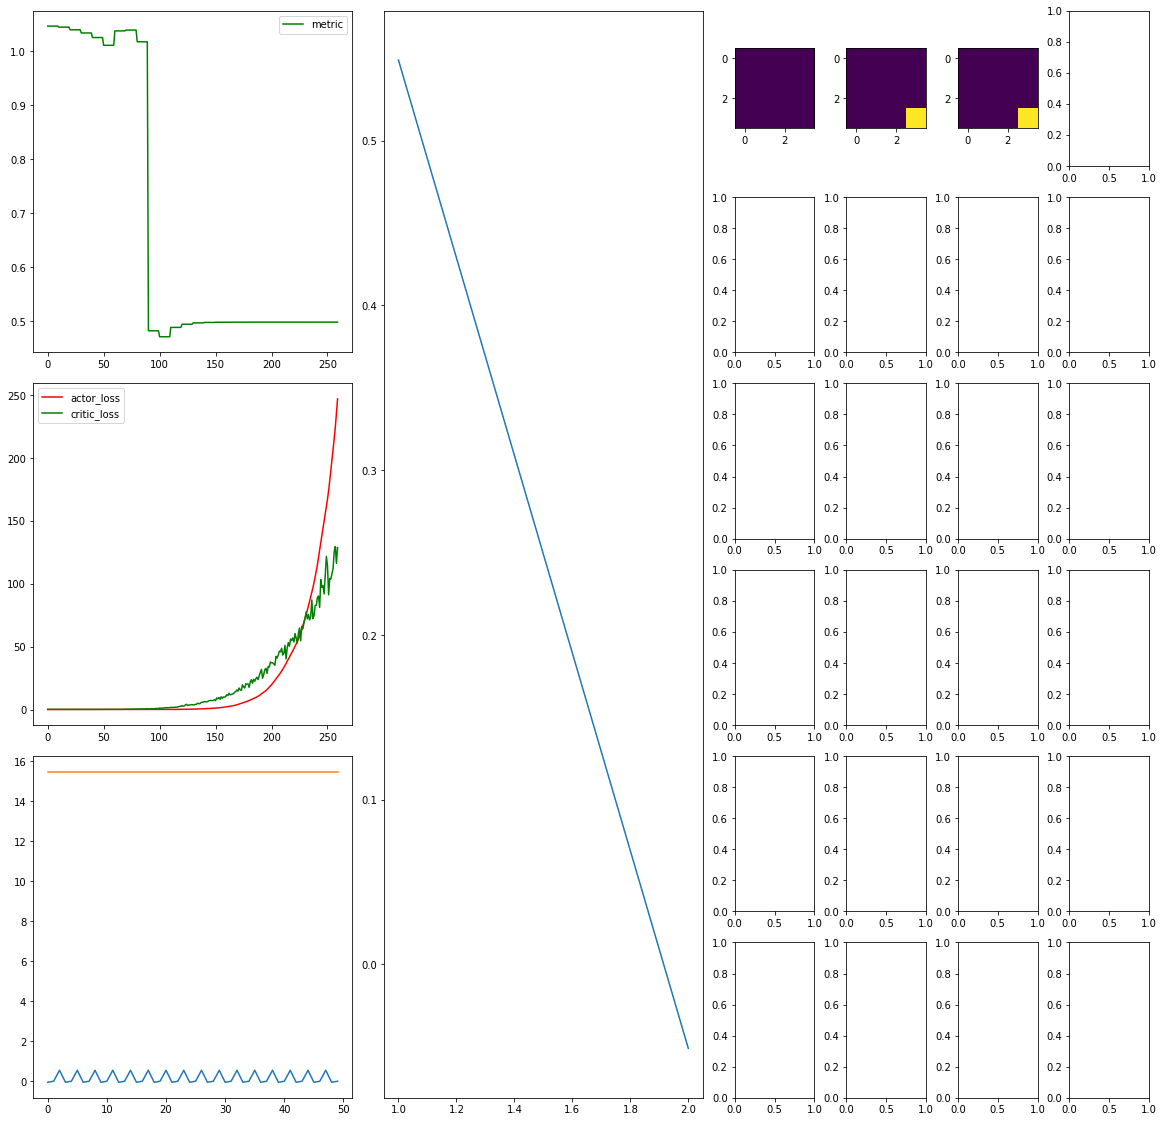

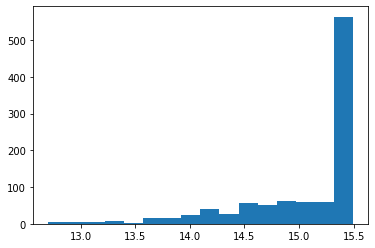

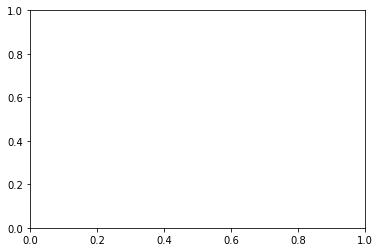

In [104]:
fig_tr = fig_trainer(6,6)
fig_dist = plt.figure()
plt.subplot()
fig_buf = plt.figure()
plt.subplot()

callbacks = [update_plotter(fig_tr),policy_plotter(fig_dist),
             output_updater(fig_tr,fig_dist),#weights_printer(1),weights_printer(5),
             buffer_plotter(fig_buf),]
trainer.run(callbacks=callbacks,
            buffer_size_increase_per_iteration = 10,
            sample_batch_size_experience = 64,
            num_iterations_train = 10,
            num_steps_per_row_in_experience = 2
           )

In [14]:
trainer.agent._critic_network.summary()

Model: "CriticNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
observation_encoding/dense ( multiple                  2550      
_________________________________________________________________
observation_encoding/dense ( multiple                  3020      
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
joint_mlp/dense (Dense)      multiple                  1100      
_________________________________________________________________
joint_mlp/dense (Dense)      multiple                

In [92]:
trainer.agent._actor_network.summary()

Model: "ActorNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_64 (Flatten)         multiple                  0         
_________________________________________________________________
input_mlp/dense (Dense)      multiple                  272       
_________________________________________________________________
permanent_variable_rate_drop multiple                  0         
_________________________________________________________________
input_mlp/dense (Dense)      multiple                  544       
_________________________________________________________________
permanent_variable_rate_drop multiple                  0         
_________________________________________________________________
input_mlp/dense (Dense)      multiple                  1056      
_________________________________________________________________
permanent_variable_rate_drop multiple                 

In [161]:
gril=np.full((1,4,4,1),0,dtype="int32")
gril[0,1,1,0]=1
obs = convert_to_tensor(gril)
trainer.agent._actor_network(obs)

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([7.462881], dtype=float32)>,
 ())

In [162]:
gril=np.full((1,4,4,1),0,dtype="int32")
gril[0,1,1,0]=1
obs = convert_to_tensor(gril)
act=np.full((1,1),7.45,dtype="float32")
obs = convert_to_tensor(gril)
act = convert_to_tensor(act)
trainer.agent._critic_network((obs,act))

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.15618034], dtype=float32)>,
 ())

In [91]:
trainer.agent._critic_network.summary()

Model: "CriticNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_65 (Flatten)         multiple                  0         
_________________________________________________________________
observation_encoding/dense ( multiple                  272       
_________________________________________________________________
observation_encoding/dense ( multiple                  272       
_________________________________________________________________
flatten_66 (Flatten)         multiple                  0         
_________________________________________________________________
action_encoding/dense (Dense multiple                  32        
_________________________________________________________________
permanent_variable_rate_drop multiple                  0         
_________________________________________________________________
action_encoding/dense (Dense multiple                